In [258]:
drive_path = '/Volumes/Brain2016'
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_rel
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
import seaborn
import h5py
# import glob
# import time as tm

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

Using matplotlib backend: MacOSX


### Import Drifting Gratings Data and Convert to Mean

In [2]:
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
# expMetaData = expMetaData[expMetaData.session_type == 'three_session_A']

In [3]:
cells = pd.DataFrame.from_records(boc.get_cell_specimens())
cells.columns

Index([u'area', u'cell_specimen_id', u'dsi_dg', u'experiment_container_id',
       u'imaging_depth', u'osi_dg', u'osi_sg', u'p_dg', u'p_ns', u'p_sg',
       u'pref_dir_dg', u'pref_image_ns', u'pref_ori_sg', u'pref_phase_sg',
       u'pref_sf_sg', u'pref_tf_dg', u'time_to_peak_ns', u'time_to_peak_sg',
       u'tld1_id', u'tld1_name', u'tld2_id', u'tld2_name', u'tlr1_id',
       u'tlr1_name'],
      dtype='object')

In [ ]:
expContainerID = expMetaData.id[8]
print(expContainerID)
exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
allCellIDs = exp.get_cell_specimen_ids()
rSpd, t_rSpd = exp.get_running_speed()

dg = DriftingGratings(exp)

In [ ]:
sResp = dg.sweep_response
sResp_mean = sResp.copy()
for i in range(sResp.shape[0]):
    if i%100 == 0:
        print(100*float(i)/sResp.shape[0], '% finished')
    for j in range(sResp.shape[1]):
        sResp_mean.iloc[i,j] = sResp_mean.iloc[i,j].mean()
print("100 % finished")

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(15, 10))

dirName = 'exp%s' % (expContainerID)
if not os.path.isdir(dirName):
    os.makedirs(dirName)

sTabl = dg.stim_table
allTF = np.sort(sTabl.temporal_frequency.unique())
allOr = np.sort(sTabl.orientation.unique())
for cell in range(sResp_mean.shape[1]-1):
    for currTF in allTF:
        for currOr in allOr:
            tmpResp = []
            tmpRun = []
            for currSweep in sTabl[(sTabl.temporal_frequency == currTF) & (sTabl.orientation == currOr)].index:
                tmpResp.append(sResp_mean[str(cell)][currSweep])
                tmpRun.append(abs(sResp_mean['dx'][currSweep]))
            axInd = np.where(allOr==currOr)[0][0]/4,np.where(allOr == currOr)[0][0]%4
            ax[axInd].scatter(tmpRun,tmpResp)
            ax[axInd].annotate("TF: %s\n"
                               "Or: %s\n" % (currTF, currOr),
                               xy=(0.8,0.9),xycoords='axes fraction',fontsize=12)
            fig.suptitle('Cell: %s\nCell ID: %s' % (cell,allCellIDs[cell]),fontsize=18)
            if axInd == (1,0):
                ax[axInd].set_xlabel('Run Speed (cm/s)')
                ax[axInd].set_ylabel('$\Delta$F/F$_0$')
            ax[axInd].set_xlim(right=1.0)
            if (np.size(tmpRun) !=0) and (max(tmpRun) > 1.0):
                ax[axInd].set_xlim(right = max(tmpRun) + 1.5)
        filename = 'cell%d_cellid%d_tf%d_or%d.pdf' % (cell, allCellIDs[cell],currTF, currOr)
        plt.pause(0.5)
        plt.savefig(dirName + '/' + filename)
        for thisAx1 in ax:
            for thisAx2 in thisAx1:
                thisAx2.cla()
        

## Import data from all DG sessions and analyze

In [7]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(15, 10))
for expContainerID in expMetaData.id[2:3]:
    print(expContainerID)
    exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
    allCellIDs = exp.get_cell_specimen_ids()
    rSpd, t_rSpd = exp.get_running_speed()

    dg = DriftingGratings(exp)

    sResp = dg.sweep_response
    sResp_mean = sResp.copy()
    for i in range(sResp.shape[0]):
        if i%100 == 0:
            print(100*float(i)/sResp.shape[0], '% finished')
        for j in range(sResp.shape[1]):
            sResp_mean.iloc[i,j] = sResp_mean.iloc[i,j].mean()
    print("100 % finished")

    dirName = 'driftingGratings/exp%s' % (expContainerID)
    if not os.path.isdir(dirName):
        os.makedirs(dirName)

    sTabl = dg.stim_table
    allTF = np.sort(sTabl.temporal_frequency.unique())
    allOr = np.sort(sTabl.orientation.unique())
    for cell in range(sResp_mean.shape[1]-1):
        for currTF in allTF:
            for currOr in allOr:
                tmpResp = []
                tmpRun = []
                for currSweep in sTabl[(sTabl.temporal_frequency == currTF) & (sTabl.orientation == currOr)].index:
                    tmpResp.append(sResp_mean[str(cell)][currSweep])
                    tmpRun.append(abs(sResp_mean['dx'][currSweep]))
                axInd = np.where(allOr==currOr)[0][0]/4,np.where(allOr == currOr)[0][0]%4
                ax[axInd].scatter(tmpRun,tmpResp)
                ax[axInd].annotate("TF: %s\n"
                                   "Or: %s\n" % (currTF, currOr),
                                   xy=(0.8,0.9),xycoords='axes fraction',fontsize=12)
                fig.suptitle('Cell: %s\nCell ID: %s' % (cell,allCellIDs[cell]),fontsize=18)
                if axInd == (1,0):
                    ax[axInd].set_xlabel('Run Speed (cm/s)')
                    ax[axInd].set_ylabel('$\Delta$F/F$_0$')
                ax[axInd].set_xlim(right=1.0)
                if (np.size(tmpRun) !=0) and (max(tmpRun) > 1.0):
                    ax[axInd].set_xlim(right = max(tmpRun) + 1.5)
            filename = 'cell%d_cellid%d_tf%d_or%d.pdf' % (cell, allCellIDs[cell],currTF, currOr)
#             plt.pause(0.5)
            plt.savefig(dirName + '/' + filename)
            for thisAx1 in ax:
                for thisAx2 in thisAx1:
                    thisAx2.cla()

508366303
(0.0, '% finished')
(15.92356687898089, '% finished')
(31.84713375796178, '% finished')
(47.77070063694268, '% finished')
(63.69426751592356, '% finished')
(79.61783439490446, '% finished')
(95.54140127388536, '% finished')
100 % finished


## Run Histograms Across All Sessions

In [110]:
expMetaData.index

0

In [117]:
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
runLen_DF = pd.DataFrame(columns=['expID','run_hist','percent_running','session_type','targeted_structure','cre_line'], index = np.arange(expMetaData.shape[0]))

dirName = 'runHistograms'
if not os.path.isdir(dirName):
    os.makedirs(dirName)

fig, ax = plt.subplots(nrows = 2)
currInd = 0
for currExpInd in expMetaData.index:
    expContainerID = expMetaData.id[currExpInd]
    
    exp = boc.get_ophys_experiment_data(ophys_experiment_id = expContainerID)
    rSpd, t_rSpd = exp.get_running_speed()
    nanMask = ~np.isnan(rSpd)
    rSpd = rSpd[nanMask]
    tmp = ax[0].hist(rSpd,bins=np.arange(-10,80),weights=np.zeros_like(rSpd) + 1. / rSpd.size)
    ax[1].hist(rSpd,bins=np.arange(-10,80),weights=np.zeros_like(rSpd) + 1. / rSpd.size)
    ax[1].set_ylim(0, max(tmp[0][20:])+.0005)
    ax[1].set_xlabel('Run Speed (cm/s)')
    percentRunning = 100*len(rSpd[rSpd>1.0])/float(len(rSpd))
    fig.suptitle('Experiment %s\n'
                 'Running >1cm/s: %d%%' % (expContainerID, percentRunning),fontsize=14)
    
    filename = 'expID%d.pdf' %(expContainerID)
#     plt.pause(0.2)
    plt.savefig(dirName + '/' + filename)
    for currAx in ax:
        currAx.cla()
    
    runLen_DF.expID[currInd] = expContainerID
    runLen_DF.run_hist[currInd] = rSpd
    runLen_DF.percent_running[currInd] = percentRunning
    runLen_DF.session_type[currInd] = expMetaData.session_type[currExpInd]
    runLen_DF.targeted_structure[currInd] = expMetaData.targeted_structure[currExpInd]
    runLen_DF.cre_line[currInd] = expMetaData.cre_line[currExpInd]
    
    'session_type','targeted_structure','cre_line'
    
    currInd += 1
    
runLen_DF.to_csv('%s/runLen_DF' %dirName, sep='\t')

## Import run histogram CSV file and use to select cells

In [4]:
runLen_DF = pd.read_csv('runHistograms/runLen_DF', delimiter='\t')
runLen_DF.drop('Unnamed: 0',1,inplace=True)

### Exclude low and high run time sessions; only look at three_session_A

In [5]:
lowLim = 30 #exclude <30% run time
upLim = 70 #exclude >70% run time
runLen_DF = runLen_DF[np.greater_equal(runLen_DF.percent_running,lowLim) & np.less_equal(runLen_DF.percent_running,upLim)]
runLen_DF = runLen_DF[runLen_DF.session_type == 'three_session_A']
runLen_DF.head()

,expID,run_hist,percent_running,session_type,targeted_structure,cre_line
4,501724959,"[-0.55685878 -0.93435436 1.56362295 ..., -0.0...",46.728607,three_session_A,VISp,Rorb-IRES2-Cre
8,507990552,"[-33.40323639 6.57465219 9.38182068 ..., ...",35.979543,three_session_A,VISl,Cux2-CreERT2
10,507464107,[ 379.40560913 42.41534042 43.07914734 ......,50.602629,three_session_A,VISal,Cux2-CreERT2
13,507881529,[ 9.88432217e+00 -7.09460318e-01 1.0165131...,52.905786,three_session_A,VISpm,Cux2-CreERT2
15,507945410,"[-0.37330681 0.16304976 -0.32720569 ..., 0.4...",32.949329,three_session_A,VISl,Rbp4-Cre


In [6]:
expID = runLen_DF.expID.iloc[0]
expContainerID = expMetaData[expMetaData.id == expID].experiment_container_id
relevCells = cells[cells.experiment_container_id == int(expContainerID)]
exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
dg = DriftingGratings(exp)
sResp = dg.sweep_response
sTabl = dg.stim_table
cellIDs = dg.cell_id
sResp_mean = sResp.copy()
for i in range(sResp.shape[0]):
    if i%100 == 0:
        print(100*float(i)/sResp.shape[0], '% finished')
    for j in range(sResp.shape[1]):
        sResp_mean.iloc[i,j] = sResp_mean.iloc[i,j].mean()
print("100 % finished")

/Users/bilalbari/anaconda/lib/python2.7/site-packages/allensdk/brain_observatory/stimulus_analysis.py:327: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = self.celltraces[nc, start:end]
/Users/bilalbari/anaconda/lib/python2.7/site-packages/allensdk/brain_observatory/stimulus_analysis.py:330: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sweep_response['dx'][index] = self.dxcm[start:end]


In [17]:
relevCells = relevCells[~np.isnan(relevCells.osi_dg) & \
                           np.less_equal(relevCells.osi_dg,1.5) & \
                           np.greater_equal(relevCells.osi_dg,0)]
relevCells.head()

,area,cell_specimen_id,dsi_dg,experiment_container_id,imaging_depth,osi_dg,osi_sg,p_dg,p_ns,p_sg,...,pref_sf_sg,pref_tf_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
1170,VISp,517404523,0.749456,511507144,275,0.575732,1.028486,2.344408e-06,1.481200e-157,6.483686e-57,...,0.04,1.0,0.29925,0.29925,179697864,Rorb-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1171,VISp,517404528,0.877868,511507144,275,1.095895,0.793717,2.888349e-19,4.573624e-29,3.547945e-04,...,0.04,4.0,0.23275,0.09975,179697864,Rorb-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1175,VISp,517404546,0.499914,511507144,275,1.039795,NaN,2.199373e-88,NaN,NaN,...,NaN,15.0,NaN,NaN,179697864,Rorb-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1176,VISp,517404552,0.792300,511507144,275,0.412933,NaN,4.875407e-15,NaN,NaN,...,NaN,1.0,NaN,NaN,179697864,Rorb-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1179,VISp,517404565,1.083675,511507144,275,1.127560,0.918176,1.293589e-15,1.130472e-17,5.030357e-07,...,0.08,4.0,0.19950,0.13300,179697864,Rorb-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [150]:
# fig,ax = plt.subplots(nrows = 2)

walkMeans = []
runMeans = []

for currCell in relevCells.index:
    cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
    prefDir = relevCells.pref_dir_dg[currCell]
    prefTF = relevCells.pref_tf_dg[currCell]
    
    allRun = []
    prefTF_mask = sTabl.temporal_frequency == prefTF
    prefDir_mask = sTabl.orientation == prefDir
    for currSweep in sTabl[prefTF_mask & prefDir_mask].index:
        allRun.append(sResp['dx'][currSweep].mean())
    if (sum(np.greater_equal(allRun,1)) >= 5) and (sum(np.less(allRun,1)) >= 5): # if <5 trials running or stationary
        runMask = np.greater_equal(allRun,1)
        stillMask = np.less(allRun,1)
        
        walkVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][stillMask]
        runVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][runMask]
#         ax[0].scatter(np.zeros_like(walkVals),walkVals)
#         ax[0].scatter(np.ones_like(runVals),runVals)
#         ax[1].scatter(sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask], allRun)
#         ax[1].set_xlabel('Cell Response')
#         ax[1].set_ylabel('Run Speed')
#         plt.pause(1.0)
        
        walkMeans.append(walkVals.mean())
        runMeans.append(runVals.mean())
#         for currAx in ax:
#             currAx.cla()
#     else:
#         print 'sad'

In [190]:
#this loads the response array and the peak dataframe from the analysis file
path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/496908818_three_session_B_analysis.h5'

#use this to load pandas dataframes
sweep_response = pd.read_hdf(path, 'analysis/sweep_response_ns')
mean_sweep_response = pd.read_hdf(path, 'analysis/mean_sweep_response_ns')

# Full DG Comparison Across All Cells

In [1]:
drive_path = '/Volumes/Brain2016'
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_rel
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
import seaborn
import h5py
# import glob
# import time as tm

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
cells = pd.DataFrame.from_records(boc.get_cell_specimens())

Using matplotlib backend: MacOSX


In [379]:
expMetaData.head()

,age_days,cre_line,experiment_container_id,id,imaging_depth,session_type,targeted_structure
0,132.0,Cux2-CreERT2,511510753,502066273,175,three_session_C,VISpm
1,116.0,Rorb-IRES2-Cre,511511001,506278598,275,three_session_B,VISpm
2,97.0,Rbp4-Cre,511510653,510529677,375,three_session_A,VISpm
3,116.0,Rorb-IRES2-Cre,511510729,504614224,275,three_session_C,VISl
4,123.0,Rorb-IRES2-Cre,511507144,501724959,275,three_session_A,VISp


In [86]:
# fig,ax = plt.subplots(nrows = 2)

walkMeans = []
runMeans = []

sessionA_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]

for expInd in sessionA_metaData.index:
    expContainerID = sessionA_metaData.experiment_container_id[expInd]
    expID = sessionA_metaData.id[expInd]
    exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
    _, dF = exp.get_dff_traces()
    
    
    path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/%d_%s_analysis.h5' % (expID, sessionA_metaData.session_type[expInd])
    sResp = pd.read_hdf(path, 'analysis/sweep_response_dg')
    sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_dg')
    sTabl = pd.read_hdf(path, 'analysis/stim_table_dg')
    cellIDs = exp.get_cell_specimen_ids()

    relevCells = cells[cells.experiment_container_id == int(expContainerID)]
    relevCells = relevCells[~np.isnan(relevCells.osi_dg) & \
                               np.less_equal(relevCells.osi_dg,1.5) & \
                               np.greater_equal(relevCells.osi_dg,0)]

    for currCell in relevCells.index:
        cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
        prefDir = relevCells.pref_dir_dg[currCell]
        prefTF = relevCells.pref_tf_dg[currCell]

        allRun = []
        prefTF_mask = sTabl.temporal_frequency == prefTF
        prefDir_mask = sTabl.orientation == prefDir
        for currSweep in sTabl[prefTF_mask & prefDir_mask].index:
            allRun.append(sResp['dx'][currSweep].mean())
        if (sum(np.greater_equal(allRun,5)) >= 5) and (sum(np.less(allRun,1)) >= 5): # if <5 trials running or stationary
            runMask = np.greater_equal(allRun,5)
            stillMask = np.less(allRun,1)

            walkVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][stillMask]
            runVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][runMask]
            
#             walkVals_fullTrace = sResp[str(cellInd)][prefTF_mask & prefDir_mask][stillMask]
#             runVals_fullTrace = sResp[str(cellInd)][prefTF_mask & prefDir_mask][runMask]

            meanFlag = False
            for tmp in walkVals:
                if np.greater_equal(tmp,50):
                    meanFlag = True
            for tmp in runVals:
                if np.greater_equal(tmp,50):
                    meanFlag = True
                    
#             for tmp in walkVals_fullTrace:
#                 if np.any(np.greater_equal(tmp,50)):
#                     meanFlag = True
#             for tmp in runVals_fullTrace:
#                 if np.any(np.greater_equal(tmp,50)):
#                     meanFlag = True
                    
            if meanFlag == True:
                walkMeans.append(walkVals.mean())
                runMeans.append(runVals.mean())
                
#             tmpResp = []
#             currInd = 0
#             for currSweep in sTabl[prefTF_mask & prefDir_mask].index:
#                 if stillMask[currInd] == True:
#                     ax[0].plot(dF[cellInd][sTabl.start[currSweep]:sTabl.start[currSweep]+120],c='black',alpha=0.6)
#                 else:
#                     ax[0].plot(dF[cellInd][sTabl.start[currSweep]:sTabl.start[currSweep]+120],c='red',alpha=0.6)
#                 currInd += 1
            
#             for currLine in sResp[str(cellInd)][prefTF_mask & prefDir_mask][stillMask]:
#                 ax[1].plot(currLine,c='black',alpha=0.6)
#             for currLine in sResp[str(cellInd)][prefTF_mask & prefDir_mask][runMask]:
#                 ax[1].plot(currLine,c='red',alpha=0.6)
# #             ax[0].scatter(np.zeros_like(walkVals),walkVals)
# #             ax[0].scatter(np.ones_like(runVals),runVals)
# #             ax[1].scatter(allRun,sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask])
# #             ax[1].set_xlabel('Run Speed')
# #             ax[1].set_ylabel('$\Delta$F/F$_0$')
#             plt.pause(1.5)
#             for currAx in ax:
#                 currAx.cla()
            

In [87]:
w_Scnn1a = np.asarray(walkMeans)
r_Scnn1a = np.asarray(runMeans)

(array([   0.,    0.,    1.,    0.,    2.,    7.,   35.,  198.,  313.,
         152.,   33.,   19.,    8.,    2.,    2.]),
 array([-200, -175, -150, -125, -100,  -75,  -50,  -25,    0,   25,   50,
          75,  100,  125,  150,  175]),
 <a list of 15 Patch objects>)

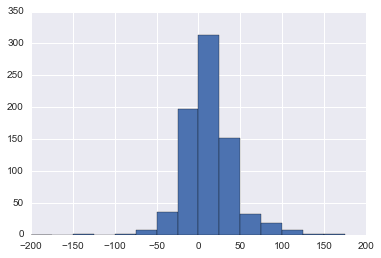

In [109]:
plt.hist(r_all - w_all,bins=np.arange(-200,200,25))

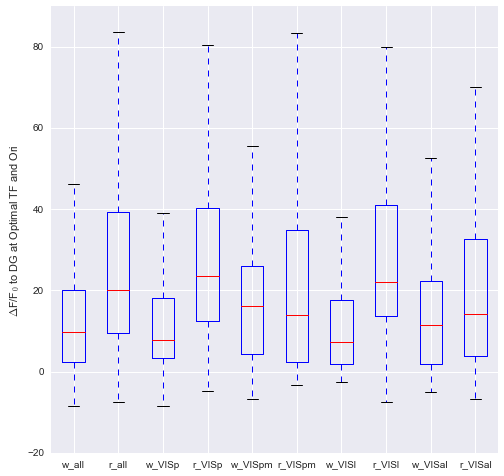

In [105]:
fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot([w_all, r_all, w_VISp, r_VISp, w_VISpm, r_VISpm, w_VISl, r_VISl, w_VISal, r_VISal],
   labels=['w_all','r_all','w_VISp','r_VISp','w_VISpm','r_VISpm','w_VISl','r_VISl','w_VISal','r_VISal'])
ax.set_ylim(-20,90)
ax.set_ylabel('$\Delta$F/F$_0$ to DG at Optimal TF and Ori')

In [52]:
currW = w_VISal
currR = r_VISal
print(currW.mean())
print(currR.mean())
print(ttest_rel(currW,currR))

18.8986536631
27.377453922
Ttest_relResult(statistic=-3.4573673632710964, pvalue=0.00072004691897799115)


In [78]:
meanResp_DF = pd.DataFrame(data = [w_all, r_all, w_VISp, r_VISp, w_VISpm, r_VISpm, w_VISl, r_VISl, w_VISal, r_VISal],index=['w_all','r_all','w_VISp','r_VISp','w_VISpm','r_VISpm','w_VISl','r_VISl','w_VISal','r_VISal'])
meanResp_DF = meanResp_DF.T
ax = seaborn.violinplot(meanResp_DF)
ax.set_ylim(-20,90)

ValueError: all the input arrays must have same number of dimensions

Ttest_relResult(statistic=-5.9309910253156968, pvalue=6.1550918087602181e-09)
Ttest_relResult(statistic=-3.876274222038087, pvalue=0.00053587221916048312)
Ttest_relResult(statistic=-10.339398851495245, pvalue=1.093471784083036e-21)
Ttest_relResult(statistic=-2.1710657657241121, pvalue=0.16208951753095432)


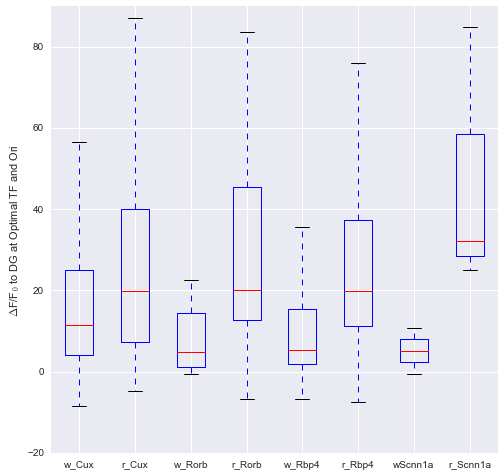

In [106]:
print(ttest_rel(w_Cux,r_Cux))
print(ttest_rel(w_Rorb,r_Rorb))
print(ttest_rel(w_Rbp4,r_Rbp4))
print(ttest_rel(w_Scnn1a,r_Scnn1a))

fig,ax = plt.subplots(figsize=(8,8))
ax.boxplot([w_Cux,r_Cux,w_Rorb,r_Rorb,w_Rbp4,r_Rbp4,w_Scnn1a,r_Scnn1a], 
    labels=['w_Cux','r_Cux','w_Rorb','r_Rorb','w_Rbp4','r_Rbp4','wScnn1a','r_Scnn1a'])
ax.set_ylim(-20,90)
ax.set_ylabel('$\Delta$F/F$_0$ to DG at Optimal TF and Ori')

In [293]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
# clf.fit([[getattr(t, 'x%d' % i) for i in range(1, 8)] for t in texts],
#         [t.y for t in texts])

y = [1,2,34,5]
x = [[1,1,2,1]]
# clf.fit([x],[y])
# clf.coef_


import statsmodels.api as sm

y = [1,2,3,4,3,4,5,4,5,5,4,5,4,5,4,5,6,5,4,5,4,3,4]

x = [
     [4,2,3,4,5,4,5,6,7,4,8,9,8,8,6,6,5,5,5,5,5,5,5],
     [4,1,2,3,4,5,6,7,5,8,7,8,7,8,7,8,7,7,7,7,7,6,5],
     [4,1,2,5,6,7,8,9,7,8,7,8,7,7,7,7,7,7,6,6,4,4,4]
     ]

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

print reg_m(y, x).summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     7.281
Date:                Wed, 31 Aug 2016   Prob (F-statistic):            0.00191
Time:                        13:33:34   Log-Likelihood:                -26.025
No. Observations:                  23   AIC:                             60.05
Df Residuals:                      19   BIC:                             64.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2424      0.139      1.739      0.0

In [278]:
# print reg_m(dF[0], rSpd)
rSpd, _ = exp.get_running_speed()
_, dF = exp.get_dff_traces()
nanMask = ~np.isnan(rSpd)
rSpd = rSpd[nanMask]
dF = dF[:,nanMask]

wtf


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115476 but corresponding boolean dimension is 115477


In [314]:
print reg_m(dF[0],[rSpd_Matx[30]]).summary()
# print len(rSpd_Matx[1]), len(dF[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5573
Date:                Wed, 31 Aug 2016   Prob (F-statistic):              0.455
Time:                        13:47:58   Log-Likelihood:             1.4178e+05
No. Observations:              115168   AIC:                        -2.836e+05
Df Residuals:                  115166   BIC:                        -2.835e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -7.854e-05      0.000     -0.746      0.4

In [349]:
from statsmodels.formula.api import ols

rSpd_Matx = []
for i in np.arange(-30,30):
    if i < 0:
        rSpd_Matx.append(np.append(np.empty(abs(i))*np.nan,rSpd[:i]))
    elif i == 0:
        rSpd_Matx.append(rSpd)
    elif i > 0:
        rSpd_Matx.append(np.append(rSpd[i:],np.empty(i)*np.nan))

for i in range(50,100):
    data = pd.DataFrame({'x0':  rSpd_Matx[ 0],  'x1': rSpd_Matx[ 1],  'x2': rSpd_Matx[ 2],  'x3': rSpd_Matx[ 3],  'x4': rSpd_Matx[ 4], 
                         'x5':  rSpd_Matx[ 5],  'x6': rSpd_Matx[ 6],  'x7': rSpd_Matx[ 7],  'x8': rSpd_Matx[ 8],  'x9': rSpd_Matx[ 9], 
                         'x10': rSpd_Matx[10], 'x11': rSpd_Matx[11], 'x12': rSpd_Matx[12], 'x13': rSpd_Matx[13], 'x14': rSpd_Matx[14], 
                         'x15': rSpd_Matx[15], 'x16': rSpd_Matx[16], 'x17': rSpd_Matx[17], 'x18': rSpd_Matx[18], 'x19': rSpd_Matx[19], 
                         'x20': rSpd_Matx[20], 'x21': rSpd_Matx[21], 'x22': rSpd_Matx[22], 'x23': rSpd_Matx[23], 'x24': rSpd_Matx[24], 
                         'x25': rSpd_Matx[25], 'x26': rSpd_Matx[26], 'x27': rSpd_Matx[27], 'x28': rSpd_Matx[28], 'x29': rSpd_Matx[29], 
                         'x30': rSpd_Matx[30], 'x31': rSpd_Matx[31], 'x32': rSpd_Matx[32], 'x33': rSpd_Matx[33], 'x34': rSpd_Matx[34], 
                         'x35': rSpd_Matx[35], 'x36': rSpd_Matx[36], 'x37': rSpd_Matx[37], 'x38': rSpd_Matx[38], 'x39': rSpd_Matx[39], 
                         'x40': rSpd_Matx[40], 'x41': rSpd_Matx[41], 'x42': rSpd_Matx[42], 'x43': rSpd_Matx[43], 'x44': rSpd_Matx[44], 
                         'x45': rSpd_Matx[45], 'x46': rSpd_Matx[46], 'x47': rSpd_Matx[47], 'x48': rSpd_Matx[48], 'x49': rSpd_Matx[49], 
                         'x50': rSpd_Matx[50], 'x51': rSpd_Matx[51], 'x52': rSpd_Matx[52], 'x53': rSpd_Matx[53], 'x54': rSpd_Matx[54], 
                         'x55': rSpd_Matx[55], 'x56': rSpd_Matx[56], 'x57': rSpd_Matx[57], 'x58': rSpd_Matx[58], 'x59': rSpd_Matx[59],
                           'y': dF[i]})                   

    # data = pd.DataFrame({'x1': rSpd, 'x2': rSpd_Matx[1], 'y': dF[0]})
    model = model = ols("y ~ x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + "
                        "x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x28 + x29 + x30 + x31 + "
                        "x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + "
                        "x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59", data).fit()
    print("%.5f" %(model.rsquared_adj))

-0.00046
0.00031
-0.00013
-0.00021
-0.00008
0.00012
-0.00028
-0.00031
0.00021
0.00323
0.00004
0.00095
0.00054
0.00117
0.00002
0.00736
-0.00008
0.00037


KeyboardInterrupt: 

IndexError: list index out of range